# Introduction




# Prepare for analysis

## Load packages

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

from titanic_analysis.read_data import load_data, quick_glimpse
from titanic_analysis.analysis import (aggregate_data, family_size, add_age_cat, fare_interval, sexandpclass,
                      apply_parsed_names, prepare, title_classification, plot_distribution)
from titanic_analysis.stats import create_missing_data_report, get_most_frequent_values, get_unique_values_count
from titanic_analysis.model import cat_to_num, split_feature_target, random_forest_prediction


In [56]:
# TODO: Add all hard coded parameters like file paths or model parameters here
TRAIN_PATH = "data/train.csv"
TEST_PATH = "data/test.csv"

n_jobs = -1
random_state = 42
criterion = "gini"
n_estimators = 100
verbose = False

## Read the data

In [57]:
train_df, test_df = load_data(TRAIN_PATH, TEST_PATH)

# Preliminary data inspection

## Quick glimpse of the data
TODO: Think if you can abstract away much here.

In [58]:
quick_glimpse(train_df, "Train Dataset")
quick_glimpse(test_df, "Test Dataset")

train_df.head()


=== Train Dataset ===
Shape: (891, 12)

First few rows:
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S 

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [59]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [60]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [61]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


In [62]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [63]:
test_df.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


## Few statistics on the data

### Missing data

In [64]:
# TODO: turn into function
missing_train = create_missing_data_report(train_df, "Train Dataset")
print(missing_train)


=== Missing Data Report: Train Dataset ===
        PassengerId Survived Pclass    Name     Sex       Age  SibSp  Parch  \
Total             0        0      0       0       0       177      0      0   
Percent         0.0      0.0    0.0     0.0     0.0  19.86532    0.0    0.0   
Types         int64    int64  int64  object  object   float64  int64  int64   

         Ticket     Fare      Cabin  Embarked  
Total         0        0        687         2  
Percent     0.0      0.0  77.104377  0.224467  
Types    object  float64     object    object  


In [65]:
# TODO: turn into function
missing_test = create_missing_data_report(test_df, "Test Dataset")
print(missing_test)


=== Missing Data Report: Test Dataset ===
        PassengerId Pclass    Name     Sex        Age  SibSp  Parch  Ticket  \
Total             0      0       0       0         86      0      0       0   
Percent         0.0    0.0     0.0     0.0  20.574163    0.0    0.0     0.0   
Types         int64  int64  object  object    float64  int64  int64  object   

             Fare      Cabin Embarked  
Total           1        327        0  
Percent  0.239234  78.229665      0.0  
Types     float64     object   object  


### Most frequent data

In [66]:
# TODO: turn into function
freq_train = get_most_frequent_values(train_df, "Train Dataset")
print(freq_train)


=== Most Frequent Values: Train Dataset ===
                   PassengerId Survived  Pclass                     Name  \
Total                      891      891     891                      891   
Most frequent item           1        0       3  Braund, Mr. Owen Harris   
Frequence                    1      549     491                        1   
Percent from total       0.112   61.616  55.107                    0.112   

                       Sex    Age   SibSp   Parch  Ticket   Fare    Cabin  \
Total                  891    714     891     891     891    891      204   
Most frequent item    male   24.0       0       0  347082   8.05  B96 B98   
Frequence              577     30     608     678       7     43        4   
Percent from total  64.759  4.202  68.238  76.094   0.786  4.826    1.961   

                   Embarked  
Total                   889  
Most frequent item        S  
Frequence               644  
Percent from total   72.441  


In [67]:
# TODO: turn into function
#total = test_df.count()
##tt = pd.DataFrame(total)
#tt.columns = ['Total']
#items = []
#vals = []
#for col in test_df.columns:
  #  try:
  #      itm = test_df[col].value_counts().index[0]
   #     val = test_df[col].value_counts().values[0]
    #    items.append(itm)
     #   vals.append(val)
  #  except Exception as ex:
   #     print(ex)
    #    items.append(0)
     #   vals.append(0)
      #  continue#
#tt['Most frequent item'] = items
#tt['Frequence'] = vals
#tt['Percent from total'] = np.round(vals / total * 100, 3)
#np.transpose(tt)

freq_test = get_most_frequent_values(test_df, "Test Dataset")
print(freq_test)


=== Most Frequent Values: Test Dataset ===
                   PassengerId  Pclass              Name     Sex   Age  \
Total                      418     418               418     418   332   
Most frequent item         892       3  Kelly, Mr. James    male  21.0   
Frequence                    1     218                 1     266    17   
Percent from total       0.239  52.153             0.239  63.636  5.12   

                     SibSp   Parch    Ticket   Fare            Cabin Embarked  
Total                  418     418       418    417               91      418  
Most frequent item       0       0  PC 17608   7.75  B57 B59 B63 B66        S  
Frequence              283     324         5     21                3      270  
Percent from total  67.703  77.512     1.196  5.036            3.297   64.593  


### Unique values

In [68]:
# TODO: turn into function
#]total = train_df.count()
#tt = pd.DataFrame(total)
#tt.columns = ['Total']
#uniques = []
#for col in train_df.columns:
 #   unique = train_df[col].nunique()
  #  uniques.append(unique)
#tt['Uniques'] = uniques
#np.transpose(tt)

unique_train = get_unique_values_count(train_df, "Train Dataset")
print(unique_train)


=== Unique Values Count: Train Dataset ===
         PassengerId  Survived  Pclass  Name  Sex  Age  SibSp  Parch  Ticket  \
Total            891       891     891   891  891  714    891    891     891   
Uniques          891         2       3   891    2   88      7      7     681   

         Fare  Cabin  Embarked  
Total     891    204       889  
Uniques   248    147         3  


In [69]:
# TODO: turn into function
unique_test = get_unique_values_count(test_df, "Test Dataset")
print(unique_test)


=== Unique Values Count: Test Dataset ===
         PassengerId  Pclass  Name  Sex  Age  SibSp  Parch  Ticket  Fare  \
Total            418     418   418  418  332    418    418     418   417   
Uniques          418       3   418    2   79      7      8     363   169   

         Cabin  Embarked  
Total       91       418  
Uniques     76         3  


# Exploratory data analysis

## Univariate analysis for all features


We show here two graphs in paralel:
* distribution of class values, split per Survived value
* comparison of class values, in train and test data


Let's first aggregate train and test data into one single dataframe, `all_df`.

In [70]:
# TODO: turn into function
#def aggregate_data(df1, df2):
  #  all_df = pd.concat([df1, df2], axis=0)
 #   all_df["set"] = "train"
 #   all_df.loc[all_df.Survived.isna(), "set"] = "test"
 #   all_df = all_df.reset_index(drop=True)
  #  return all_df

#all_df = aggregate_data(train_df, test_df)

#def add_age_cat(df):
 #   df["Age Interval"] = 0.0
   # df.loc[ df['Age'] <= 16, 'Age Interval']  = 0
   # df.loc[(df['Age'] > 16) & (df['Age'] <= 32), 'Age Interval'] = 1
  #  df.loc[(df['Age'] > 32) & (df['Age'] <= 48), 'Age Interval'] = 2
 #   df.loc[(df['Age'] > 48) & (df['Age'] <= 64), 'Age Interval'] = 3
 #   df.loc[ df['Age'] > 64, 'Age Interval'] = 4
 #   return df

#all_df = add_age_cat(all_df)

all_df = aggregate_data(train_df, test_df)



In [71]:
all_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,set
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,train
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,train
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,train
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,train
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,train


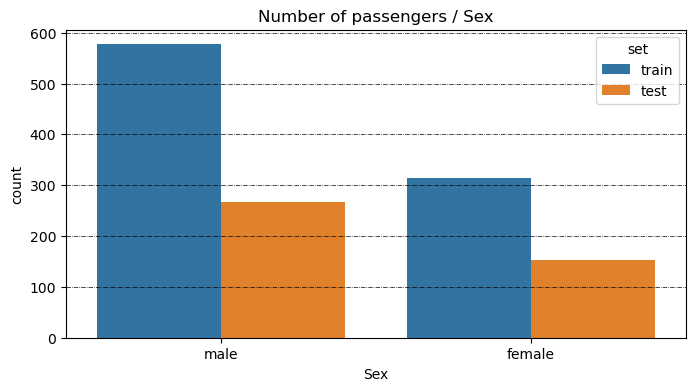

In [72]:
color_list = ["#A5D7E8", "#576CBC", "#19376D", "#0b2447"]

def plot_count_pairs(column, df, huevar="set"):
    f, ax = plt.subplots(1, 1, figsize=(8, 4))
    sns.countplot(x=column, data=df, hue=huevar)
    plt.grid(color="black", linestyle="-.", linewidth=0.5, axis="y", which="major")
    ax.set_title(f"Number of passengers / {column}")
    plt.show() 
    
plot_count_pairs("Sex", all_df) 

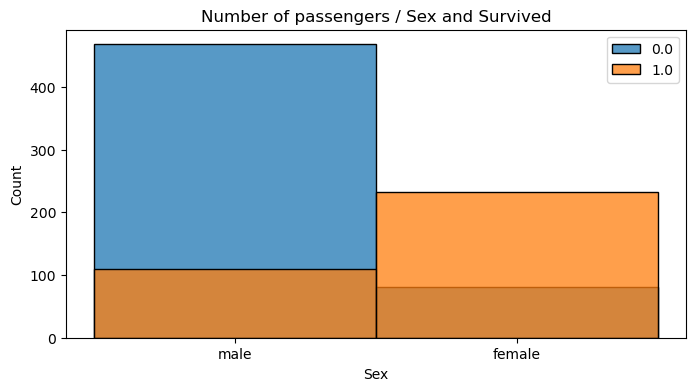

In [73]:
# Plot distribution pairs for "Sex" and hue as "Survived"
def plot_distribution_pairs(distcol, huecol, df):
    f, ax = plt.subplots(1, 1, figsize=(8, 4))
    for i, h in enumerate(df[huecol].unique()):
        g = sns.histplot(df.loc[df[huecol]==h, distcol], 
                                    ax=ax, 
                                    label=h)
    ax.set_title(f"Number of passengers / {distcol} and {huecol}")
    g.legend()
    plt.show()
    
plot_distribution_pairs("Sex", "Survived", all_df)

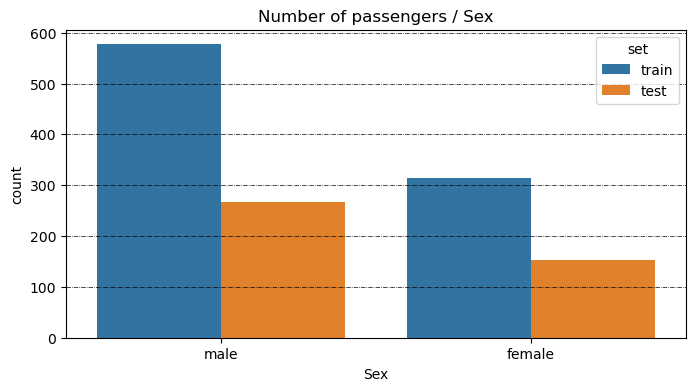

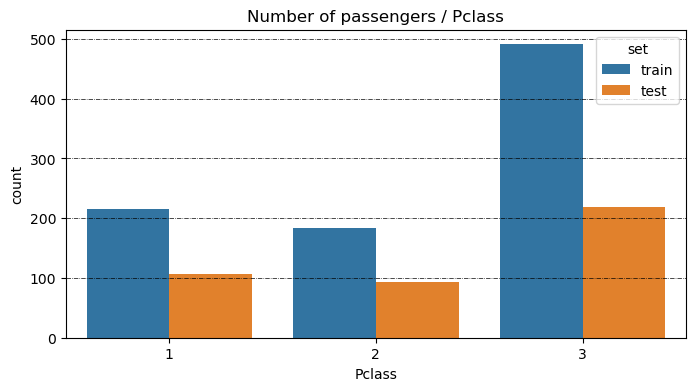

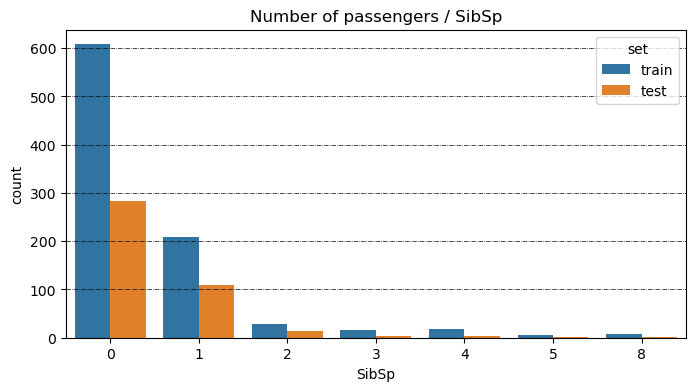

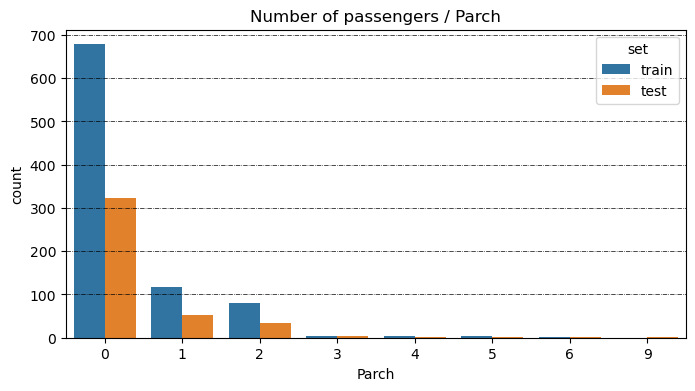

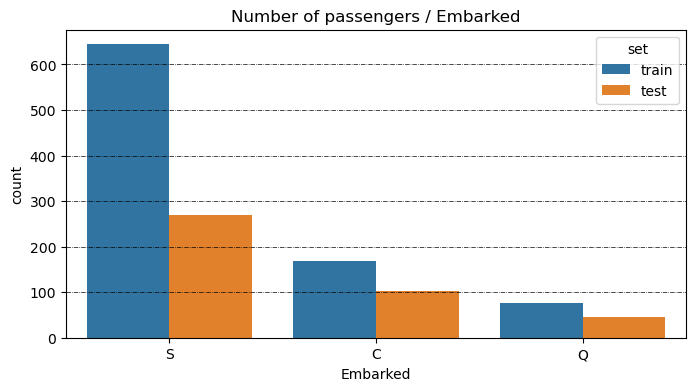

In [74]:
# Plot count pairs using all_df for the columns: Sex, Pclasss, SibSp, Parch, Embarked
for col in ["Sex", "Pclass", "SibSp", "Parch", "Embarked"]:
    plot_count_pairs(col, all_df)
     

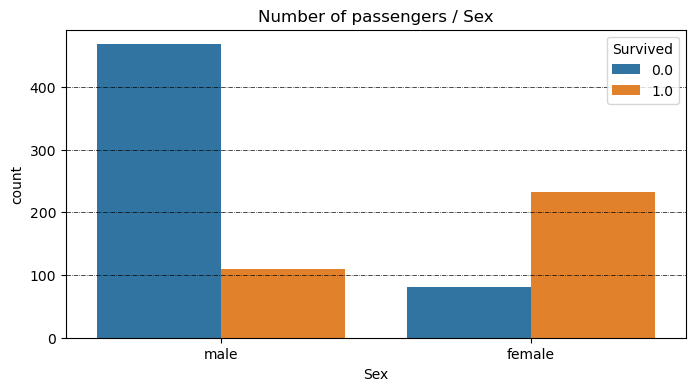

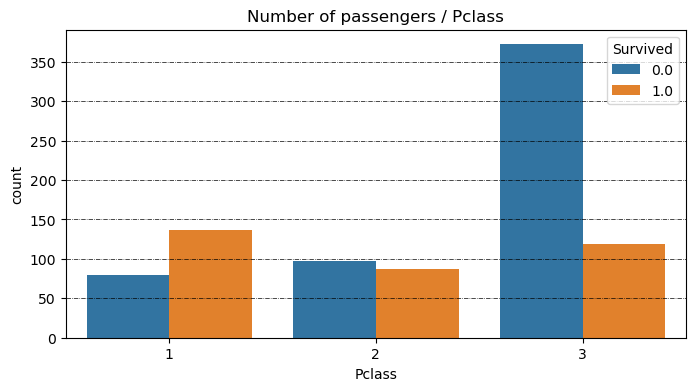

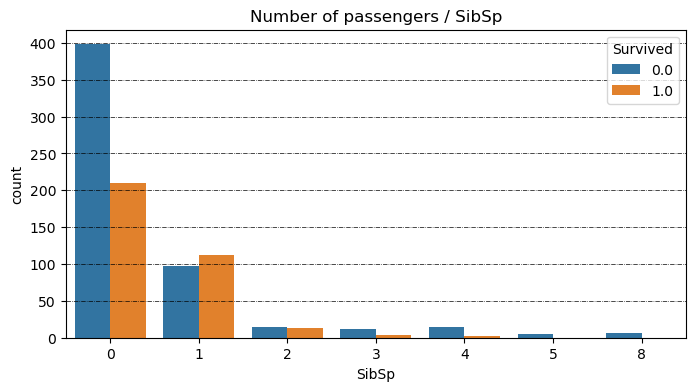

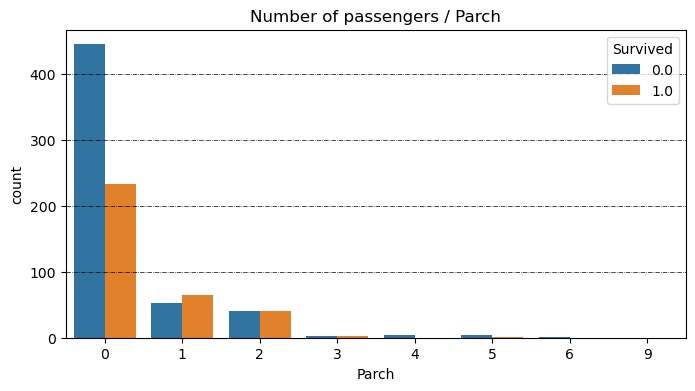

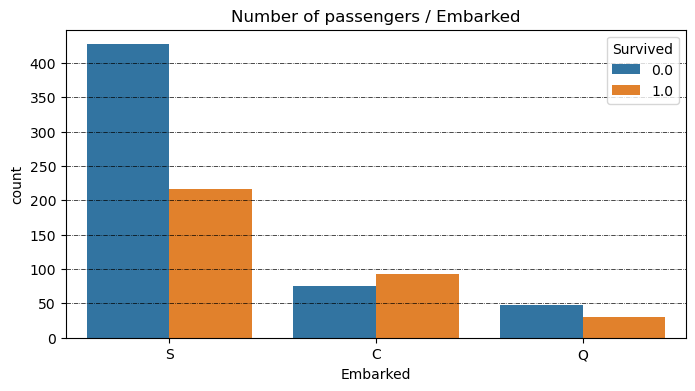

   PassengerId  Survived  Pclass  \
0            1       0.0       3   
1            2       1.0       1   
2            3       1.0       3   
3            4       1.0       1   
4            5       0.0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked    set  
0      0         A/5 21171   7.2500   NaN        S  train  
1      0          PC 17599  71.2833   C85        C  train  
2      0  STON/O2. 3101282   7.9250   NaN        S  train  
3      0            113803  53.1000  C123        S  train  
4      0            

In [75]:
# Plot count pairs using all_df for the columns: Sex, Pclasss, SibSp, Parch, Embarked and use "Survived" as hue.
for col in ["Sex", "Pclass", "SibSp", "Parch", "Embarked"]:
    plot_count_pairs(col, all_df, huevar="Survived")
    
print(all_df.head())

In [81]:
all_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,set
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,train
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,train
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,train
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,train
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,test
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,test
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,test
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,test


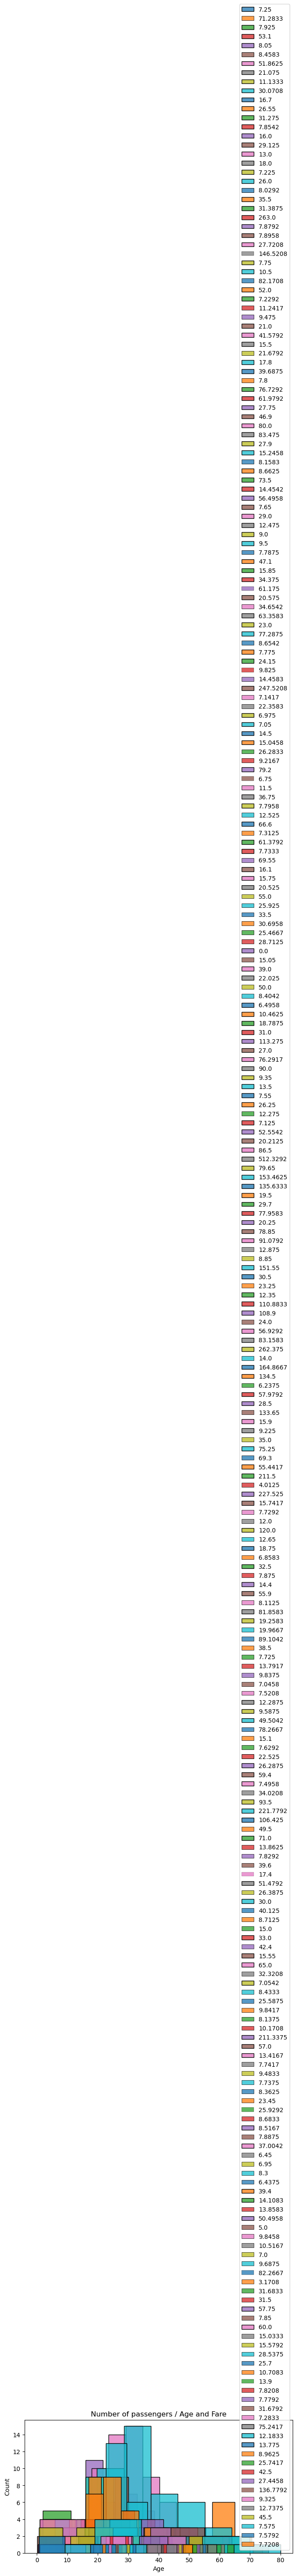

In [ ]:
# Plot distribution pairs for Age and Fare
plot_distribution("Age", df = all_df)
plot_distribution("Fare", df = all_df)

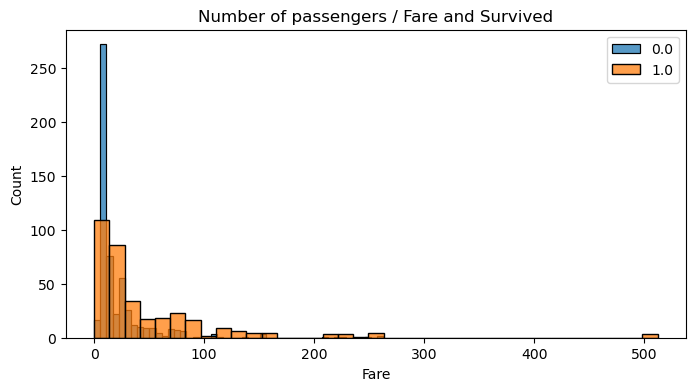

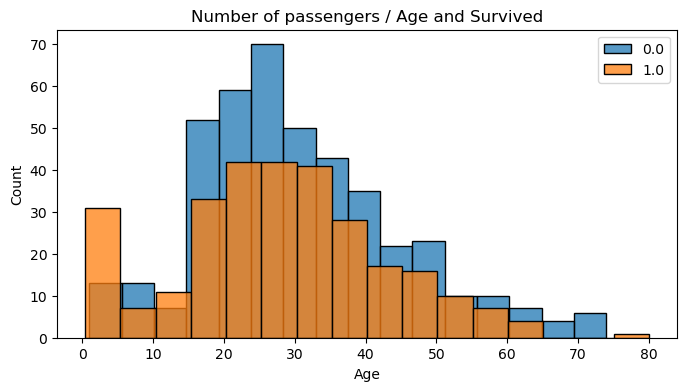

In [ ]:
# Plot distribution pairs for Age and Fare using "Survived" as hue
plot_distribution_pairs("Fare", "Survived", all_df)
plot_distribution_pairs("Age", "Survived", all_df)

## Family size


Based on SibSp (sibilings or spouse) and Parch (parents or children), we set the Family Size field.

In [ ]:
# TODO: turn into function
#def family_size(df):
    #df["Family Size"] = df["SibSp"] + df["Parch"] + 1
    #return df
#all_df = family_size(all_df)
for dataset in [all_df, train_df]:
    dataset = family_size(dataset)

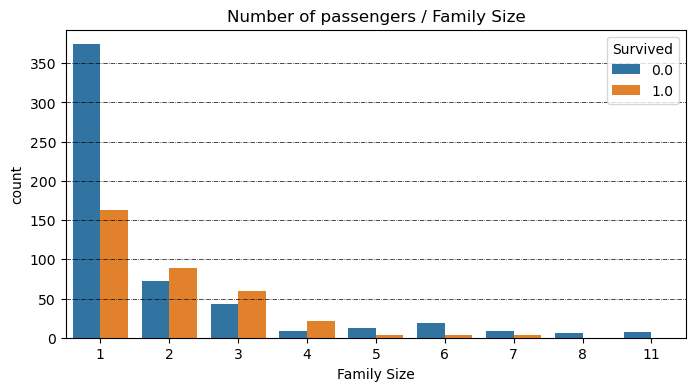

In [ ]:
# Plot count pairs using all_df for the column "Family Size" and use "Survived" as hue.
plot_count_pairs("Family Size", all_df, huevar="Survived")

## Age interval

In [ ]:
# TODO: turn into function
#def add_age_cat(df):
    #df["Age Interval"] = 0.0
    #df.loc[ df['Age'] <= 16, 'Age Interval']  = 0
    #df.loc[(df['Age'] > 16) & (df['Age'] <= 32), 'Age Interval'] = 1
    #df.loc[(df['Age'] > 32) & (df['Age'] <= 48), 'Age Interval'] = 2
    #df.loc[(df['Age'] > 48) & (df['Age'] <= 64), 'Age Interval'] = 3
    #df.loc[ df['Age'] > 64, 'Age Interval'] = 4
    #return df

#print(add_age_cat(all_df)["Age Interval"])
for dataset in [all_df, train_df]:
    dataset = add_age_cat(dataset)


In [ ]:
# TODO: turn into function
#train_df["Age Interval"] = 0.0
#train_df.loc[train_df['Age'] <= 16, 'Age Interval']  = 0
#train_df.loc[(train_df['Age'] > 16) & (train_df['Age'] <= 32), 'Age Interval'] = 1
#train_df.loc[(train_df['Age'] > 32) & (train_df['Age'] <= 48), 'Age Interval'] = 2
#train_df.loc[(train_df['Age'] > 48) & (train_df['Age'] <= 64), 'Age Interval'] = 3
#train_df.loc[ train_df['Age'] > 64, 'Age Interval'] = 4

In [ ]:
all_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,set,Family Size,Age Interval
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,train,2,1.0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,train,2,2.0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,train,1,1.0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,train,2,2.0
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,train,1,2.0


In [ ]:
# Plot count pairs using all_df for the column "Age Interval" and use "Survived" as hue.

## Fare interval

In [ ]:
# TODO: turn into function
#d#ef fare_interval(df):
  #  df['Fare Interval'] = 0.0
   # df.loc[ df['Fare'] < 7.9, 'Fare Interval'] = 0
   # df.loc[(df['Fare'] > 7.91) & (df['Fare'] < 14.453), 'Fare Interval'] = 1
   # df.loc[(df['Fare'] > 14.454) & (df['Fare'] < 31), 'Fare Interval']   = 2
  #  df.loc[ df['Fare'] > 31.001, 'Fare Interval'] = 3
  #  return df
#all_df = fare_interval(all_df)

In [ ]:
# TODO: turn into function
#train_df['Fare Interval'] = 0.0
#train_df.loc[ train_df['Fare'] <= 7.91, 'Fare Interval'] = 0
#train_df.loc[(train_df['Fare'] > 7.91) & (train_df['Fare'] <= 14.454), 'Fare Interval'] = 1
#train_df.loc[(train_df['Fare'] > 14.454) & (train_df['Fare'] <= 31), 'Fare Interval']   = 2
#train_df.loc[ train_df['Fare'] > 31, 'Fare Interval'] = 3
for dataset in [all_df, train_df]:
    dataset = fare_interval(dataset)

In [ ]:
# Plot count pairs using all_df for the column "Fare Interval"

Let's create a composed feature: Pclass + Sex.

In [ ]:
# TODO: turn into function
#def sexandpclass(df):
    #df["Sex_Pclass"] = df.apply(lambda row: row['Sex'][0].upper() + "_C" + str(row["Pclass"]), axis=1)
    #return df
for dataset in [all_df, train_df]:
    dataset = sexandpclass(dataset)

In [ ]:
# TODO: turn into function
#all_df["Sex_Pclass"] = all_df.apply(lambda row: row['Sex'][0].upper() + "_C" + str(row["Pclass"]), axis=1)
#print(all_df.head())

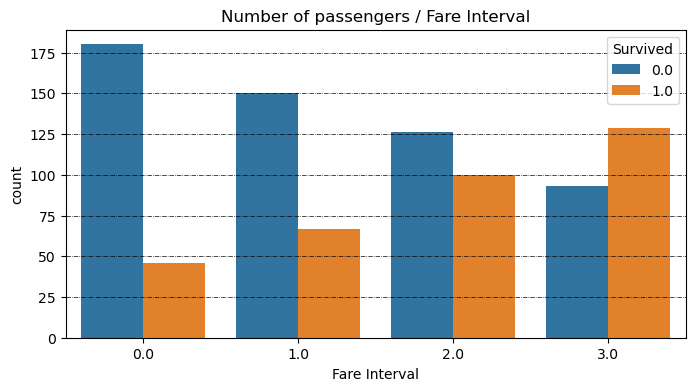

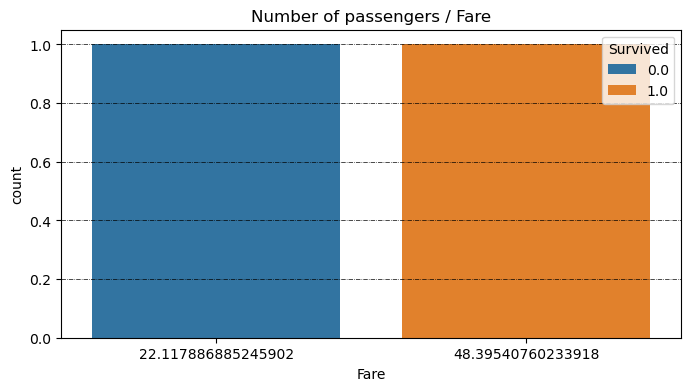

In [ ]:
# Plot count pairs using all_df for the column "Fare Interval" and "Fare (grouped by survival)" with "Survived" as hue
all_df_gb_survival = all_df.groupby(by="Survived").mean(numeric_only=True)
plot_count_pairs("Fare Interval", all_df, huevar="Survived")
plot_count_pairs("Fare", all_df_gb_survival, huevar="Survived")

## Process names


When we process names, we would like to extract the following information:

- Family name - this is the first word (or few first words, if a family name with multiple names), followed by a comma  
- Title - this follows just after the comma   
- Given name - this is the word or group of words following family name  
- Maiden name - for ladies, is given between parantheses  

We start with creating a function that parses the Name string and extract (if possible) these 4 elements


In [ ]:
# TODO: also move this function to a separate file
#def parse_names(row):
   # try:
     #   text = row["Name"]
     #   split_text = text.split(",")
      #  family_name = split_text[0]
      #  next_text = split_text[1]
      #  split_text = next_text.split(".")
      #  title = (split_text[0] + ".").lstrip().rstrip()
      #  next_text = split_text[1]
      #  if "(" in next_text:
      #      split_text = next_text.split("(")
      #      given_name = split_text[0]
      #      maiden_name = split_text[1].rstrip(")")
      #      return pd.Series([family_name, title, given_name, maiden_name])
      #  else:
      #      given_name = next_text
      #      return pd.Series([family_name, title, given_name, None])
    #except Exception as ex:
     #   print(f"Exception: {ex}")

for dataset in [all_df, train_df]:
  dataset = apply_parsed_names(dataset)

In [ ]:
# TODO: turn into function
#train_df[["Family Name", "Title", "Given Name", "Maiden Name"]] = train_df.apply(lambda row: parse_names(row), axis=1)

all_df = prepare(all_df)
train_df = prepare(train_df)
all_df = title_classification(all_df)
train_df = title_classification(train_df)

## Multivariate analysis


Let's look now to the interaction of multiple features.

In [ ]:
# TODO: Plot count pairs of "Age Interval" grouped by "Pclass"
#all_df_gb_pclass = all_df.groupby(by="Pclass").mean(numeric_only=True)
#plot_count_pairs("Age Interval", all_df, huevar="Pclass")

sex_pclass_map = {k: i for i, k in enumerate(all_df['Sex_Pclass'].unique())}
all_df = cat_to_num(all_df, "Sex_Pclass", sex_pclass_map)

In [ ]:
# TODO: Plot count pairs of "Age Interval" grouped by "Embarked"
#all_df_gb_embarked = all_df.groupby(by="Embarked").mean(numeric_only=True)
#plot_count_pairs("Age Interval", all_df, huevar="Embarked")

In [ ]:
# TODO: Plot count pairs of "Pclass" grouped by "Fare Interval"
#all_df_gb_fareinterval = all_df.groupby(by="Fare Interval").mean(numeric_only=True)
#plot_count_pairs("Pclass", all_df, huevar="Fare Interval")

### Few more engineered data 


Let's create two more engineered features:  
* Family size interval: Single, Small, Large  
* Aggregated titles: Mr, Mrs, Master, Miss, and Rare  

In [ ]:
# TODO: turn into function

#for dataset in [all_df, train_df]:
 #   dataset["Family Type"] = dataset["Family Size"]

predictors = ["Pclass", "Sex_Pclass", "Family Size", "Age Interval", "Fare Interval"]


In [ ]:
# TODO: turn into function
#for dataset in [all_df, train_df]:
   # dataset.loc[dataset["Family Size"] == 1, "Family Type"] = "Single"
    #dataset.loc[(dataset["Family Size"] > 1) & (dataset["Family Size"] < 5), "Family Type"] = "Small"
    #dataset.loc[(dataset["Family Size"] >= 5), "Family Type"] = "Large"

In [ ]:
for dataset in [all_df, train_df]:
    dataset["Titles"] = dataset["Title"]

In [ ]:
# TODO: turn into function
#for dataset in [all_df, train_df]:
  #  #unify `Miss`
  #  dataset['Titles'] = dataset['Titles'].replace('Mlle.', 'Miss.')
   # dataset['Titles'] = dataset['Titles'].replace('Ms.', 'Miss.')
   # #unify `Mrs`
   # dataset['Titles'] = dataset['Titles'].replace('Mme.', 'Mrs.')
   # # unify Rare
  #  dataset['Titles'] = dataset['Titles'].replace(['Lady.', 'the Countess.','Capt.', 'Col.',\
   #  'Don.', 'Dr.', 'Major.', 'Rev.', 'Sir.', 'Jonkheer.', 'Dona.'], 'Rare')

In [ ]:
# TODO: turn into function
#train_df[['Titles', 'Sex', 'Survived']].groupby(['Titles', 'Sex'], as_index=False).mean()##

# Split train data
train_data = all_df[all_df['set'] == 'train']
train_X, train_y = split_feature_target(train_data, predictors, "Survived")

# Split test data
test_data = all_df[all_df['set'] == 'test']
test_X = test_data[predictors]

preds_train, preds_test = random_forest_prediction(
    train_X, train_y, test_X,
    n_jobs=n_jobs,
    random_state=random_state,
    criterion=criterion,
    n_estimators=n_estimators,
    verbose=verbose
)

# Baseline model

## Feature engineering: Map categorical value to numerical values

In [ ]:
for dataset in [train_df, test_df]:
    dataset = cat_to_num(dataset, 'Sex', {'female': 1, 'male': 0})

Create train-validation split.

In [ ]:
VALID_SIZE = 0.2
train, valid = train_test_split(train_df, test_size=VALID_SIZE, random_state=42, shuffle=True)

Define predictor features and target feature.

In [ ]:
predictors = ["Sex", "Pclass"]
target = 'Survived'

Define the training and validation data and labels.

In [ ]:
train_X, train_Y = split_feature_target(train, predictors, target)
valid_X, valid_Y = split_feature_target(valid, predictors, target)

Fit the classifiction algorithm with the training data, and predict the train data (to check the training classification error) and the validation data.

In [ ]:
preds_tr, preds  = random_forest_prediction(train_X, train_Y, valid_X, n_jobs, random_state, criterion, n_estimators, verbose=False)

# Evaluation

## Classification report for training data.

In [ ]:
print(metrics.classification_report(train_Y, preds_tr, target_names=['Not Survived', 'Survived']))

              precision    recall  f1-score   support

Not Survived       0.75      0.99      0.86       444
    Survived       0.96      0.47      0.63       268

    accuracy                           0.79       712
   macro avg       0.86      0.73      0.74       712
weighted avg       0.83      0.79      0.77       712



Classification report for validation data.

In [ ]:
print(metrics.classification_report(valid_Y, preds, target_names=['Not Survived', 'Survived']))

              precision    recall  f1-score   support

Not Survived       0.73      0.96      0.83       105
    Survived       0.90      0.49      0.63        74

    accuracy                           0.77       179
   macro avg       0.81      0.72      0.73       179
weighted avg       0.80      0.77      0.75       179



In [ ]:
train_accuracy = (preds_train == train_y).mean()
print(f"Training Accuracy: {train_accuracy:.4f}")

submission_df = test_data[["PassengerId"]].copy()
submission_df["Survived"] = preds_test
submission_df.head()

Training Accuracy: 0.8620


,PassengerId,Survived
891,892,0.0
892,893,0.0
893,894,0.0
894,895,0.0
895,896,0.0
